In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from skopt import BayesSearchCV
from scipy.stats import iqr
#from libsvm.svmutil import *

In [5]:
train_df = pd.read_csv('kaggle/html2023-spring-final-project/train.csv')
train_df['Album_type'] = [1.0 if i == 'single' else (2.0 if i == 'album' else 3.0) for i in train_df['Album_type']]
train_df_bool = train_df[['Licensed', 'official_video']]
train_df_cat = train_df[['Artist', 'Composer']]
train_x_o = train_df.iloc[:, list(train_df.dtypes == float)]
train_y = train_x_o.iloc[:, 0]
train_x_o = train_x_o.iloc[:, 1:]
train_x_lm = pd.concat([train_df_bool, train_x_o], axis=1)

# Descriptive statistics: original data

In [6]:
Q1 = lambda x: x.quantile(0.25)
Q1.__name__ = 'Q1'
Q3 = lambda x: x.quantile(0.75)
Q3.__name__ = 'Q3'

des_all = train_x_lm.agg([np.min, np.max, np.mean, np.std, Q1, np.median, Q3])
des_level = train_x_lm.groupby(train_y).agg([np.min, np.max, np.mean, np.std, Q1, np.median, Q3])

In [7]:
des_all.to_csv('des_all.csv')
des_all

,Licensed,official_video,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Stream,Album_type,Comments
amin,False,False,8.365427e-15,0.000000,-46.251000,0.000000,1.367631e-18,0.000000,0.000003,0.000000,0.000000,3.098500e+04,2.600000e+01,0.000000e+00,6.574000e+03,1.000000,0.000000e+00
amax,True,True,1.000000e+00,10.000000,0.829000,0.964000,9.880479e-01,1.000000,1.000000,0.993000,243.372000,4.581483e+06,5.773798e+09,4.014762e+07,3.386520e+09,3.000000,1.608314e+07
mean,0.703849,0.789488,3.358392e-01,5.231604,-7.561370,0.095462,1.148404e-01,0.054934,0.033745,0.525842,120.937819,2.228307e+05,8.791096e+07,6.485064e+05,1.290426e+08,1.960804,2.810321e+04
std,0.456574,0.407686,2.426825e-01,3.456986,4.540944,0.103068,2.215160e-01,0.191392,0.114862,0.244912,29.665225,1.211659e+05,2.523918e+08,1.726157e+06,2.417681e+08,0.627696,2.142922e+05
Q1,0.0,1.0,1.342177e-01,2.000000,-8.655000,0.036100,9.797218e-05,0.000000,0.000836,0.336000,97.041000,1.793055e+05,1.971684e+06,2.251600e+04,1.628195e+07,2.000000,5.340000e+02
median,1.0,1.0,2.954083e-01,5.000000,-6.472000,0.051400,6.967871e-03,0.000002,0.001907,0.531000,119.995500,2.120300e+05,1.427208e+07,1.239210e+05,4.550224e+07,2.000000,3.171000e+03
Q3,1.0,1.0,5.062616e-01,8.000000,-4.920000,0.106000,1.025032e-01,0.000392,0.012487,0.722000,139.990250,2.495115e+05,6.603988e+07,5.077155e+05,1.256493e+08,2.000000,1.361900e+04


In [8]:
des_level.to_csv('des_level.csv')
des_level

Licensed                                             \
                 amin  amax      mean       std   Q1 median   Q3   
Danceability                                                       
0.0             False  True  0.679030  0.467016  0.0    1.0  1.0   
1.0             False  True  0.694185  0.460917  0.0    1.0  1.0   
2.0             False  True  0.706647  0.455463  0.0    1.0  1.0   
3.0             False  True  0.711888  0.453042  0.0    1.0  1.0   
4.0             False  True  0.704480  0.456441  0.0    1.0  1.0   
5.0             False  True  0.695862  0.460200  0.0    1.0  1.0   
6.0             False  True  0.721871  0.448219  0.0    1.0  1.0   
7.0             False  True  0.717617  0.450305  0.0    1.0  1.0   
8.0             False  True  0.718653  0.449797  0.0    1.0  1.0   
9.0             False  True  0.682562  0.465645  0.0    1.0  1.0   

             official_video                  ... Album_type              \
                       amin  amax      mean  ...         Q1 median   Q3   
Danceability                                 ...                          
0.0                   False  True  0.739658  ...        2.0    2.0  2.0   
1.0                   False  True  0.770909  ...        2.0    2.0  2.0   
2.0                   False  True  0.793931  ...        2.0    2.0  2.0   
3.0                   False  True  0.793007  ...        2.0    2.0  2.0   
4.0                   False  True  0.786485  ...        2.0    2.0  2.0   
5.0                   False  True  0.786367  ...        2.0    2.0  2.0   
6.0                   False  True  0.816248  ...        1.0    2.0  2.0   
7.0                   False  True  0.818354  ...        1.0    2.0  2.0   
8.0                   False  True  0.798854  ...        1.0    2.0  2.0   
9.0                   False  True  0.783039  ...        1.0    2.0  2.0   

             Comments                                                   \
                 amin        amax          mean            std      Q1   
Danceability                                                             
0.0               0.0    618868.0  11666.689606   36354.872183  118.50   
1.0               0.0   1250054.0  14909.721323   50634.032500  447.00   
2.0               0.0   1090717.0  16308.497502   56529.510461  624.00   
3.0               0.0   2984558.0  21712.053495  100472.841270  587.50   
4.0               0.0   3109122.0  23674.021337  116314.006788  558.50   
5.0               0.0   6535721.0  33766.186722  274083.036698  461.50   
6.0               0.0   3486944.0  32639.115090  154794.695258  715.25   
7.0               0.0  16083138.0  54620.219054  518067.244188  595.50   
8.0               0.0   5130725.0  36603.296086  181287.253006  810.00   
9.0               0.0   1485737.0  30714.601261   94399.763365  877.50   

                                
              median        Q3  
Danceability                    
0.0           1429.0   7362.00  
1.0           2695.0  10144.00  
2.0           2924.0  10762.00  
3.0           3108.5  11731.50  
4.0           2956.5  12062.50  
5.0           2889.0  12804.00  
6.0           3557.5  15027.75  
7.0           3963.0  19020.50  
8.0           4402.5  19109.00  
9.0           5281.0  21358.00  

[10 rows x 119 columns]

# Boxplots: original data

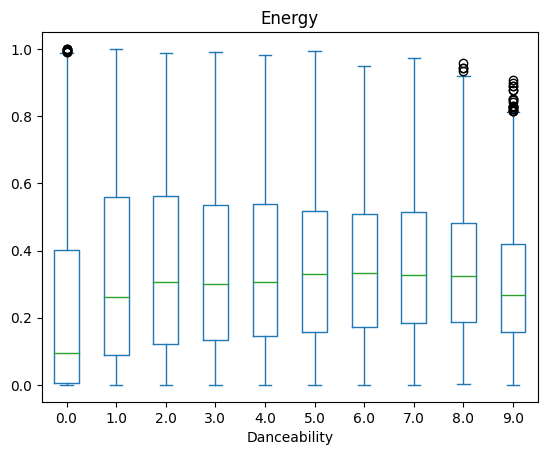

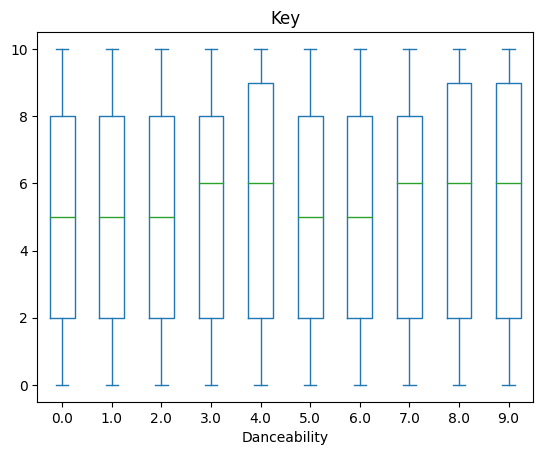

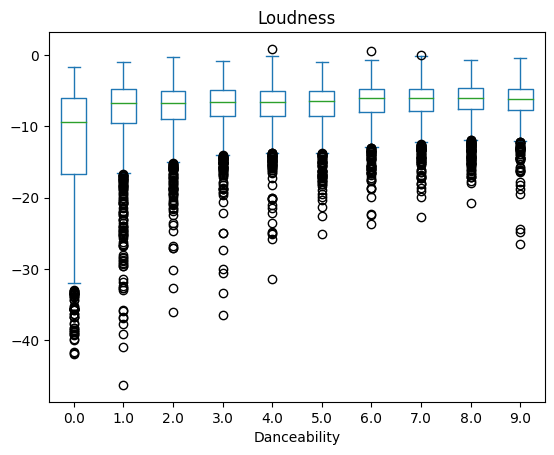

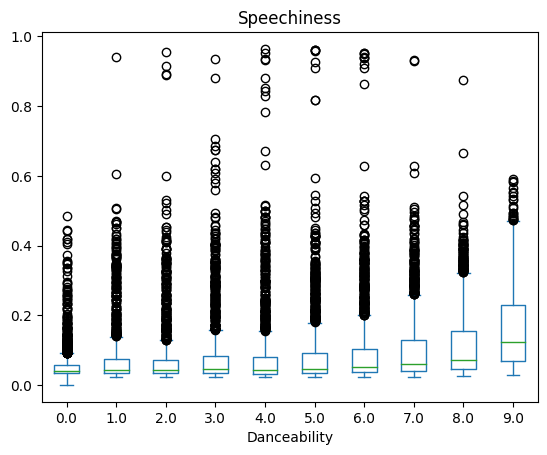

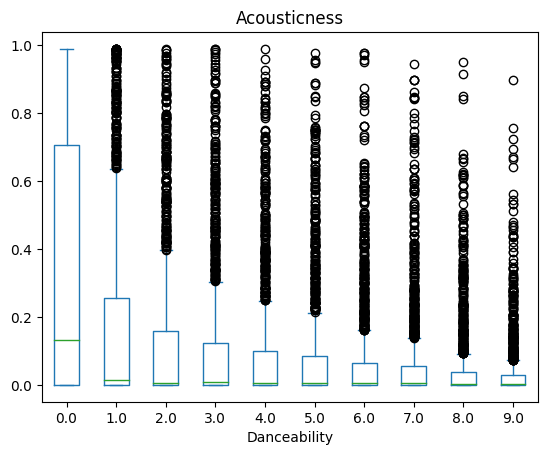

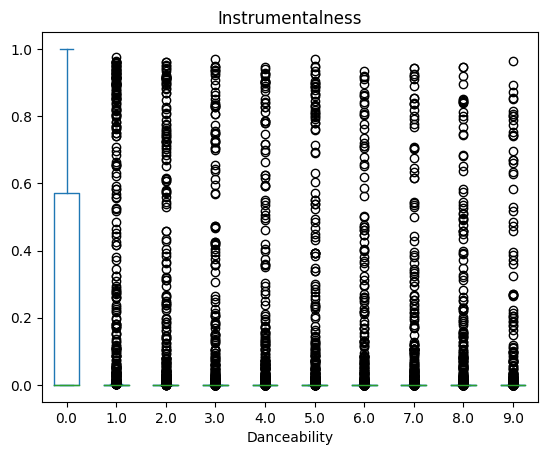

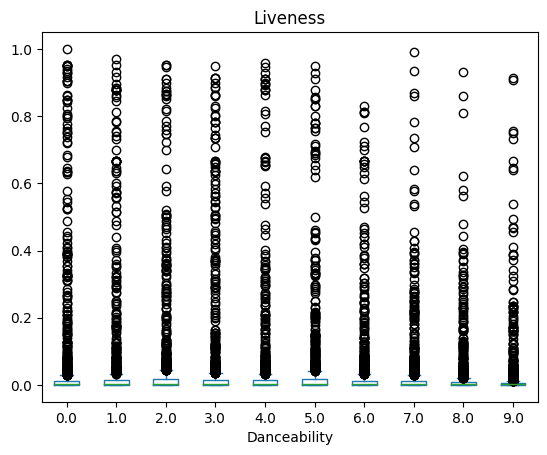

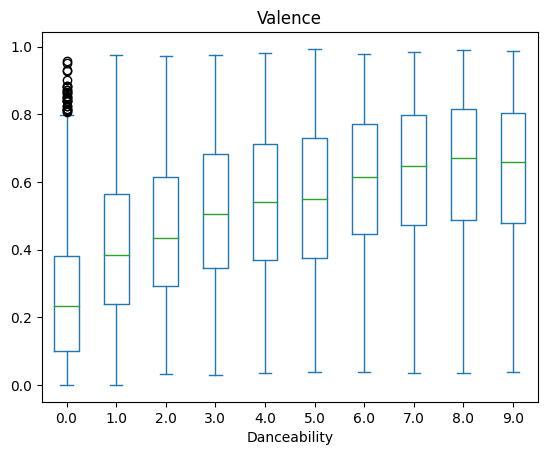

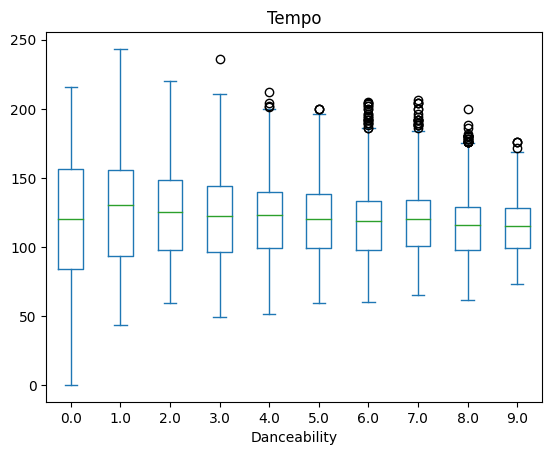

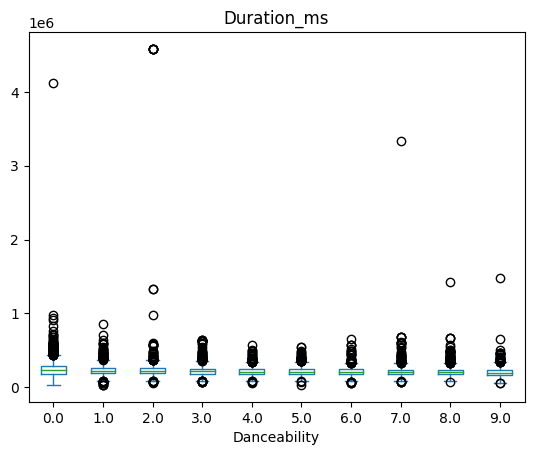

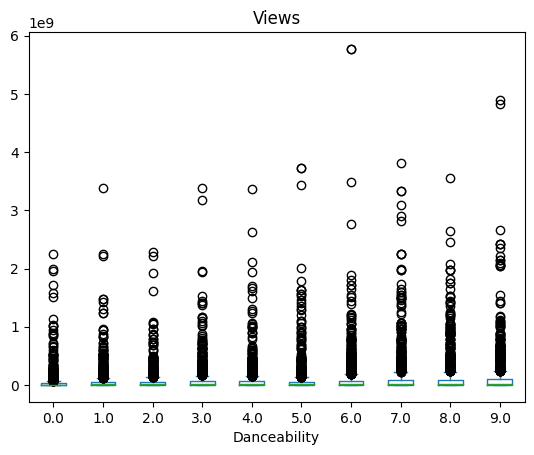

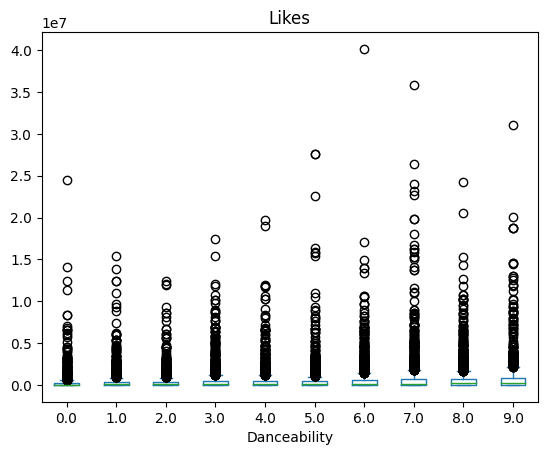

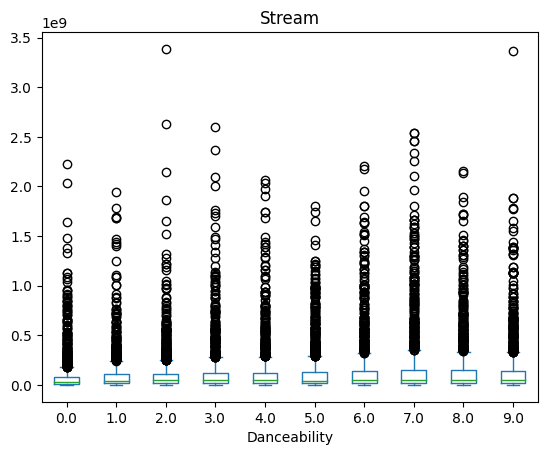

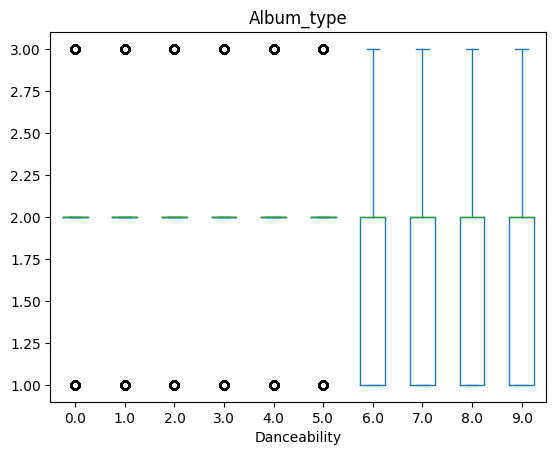

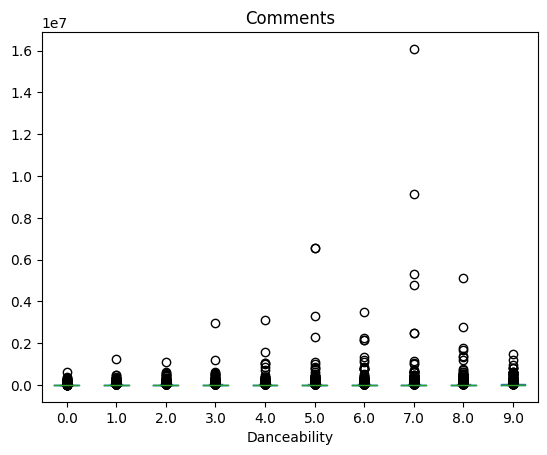

In [9]:
for i in range(train_x_o.shape[1]):
    pd.DataFrame({'Danceability': train_y, train_x_o.columns[i]: train_x_o[train_x_o.columns[i]]}).plot(kind='box',by='Danceability')
    plt.xlabel('Danceability')
    plt.show()

# Use log and IQR to scale data for knn

In [10]:
def plus1_log_scale(x):
    return np.emath.logn(10000, 10000 * x + 1)

In [28]:
class SP_KNN:
    def __init__(self):
        self.base = [2e6, 3e9, 2e7, 2e9, 1e7]

    def fit(self, df):
        self.df = df.copy()
        self.df['Album_type'] = [1.0 if i == 'single' else (2.0 if i == 'album' else 3.0) for i in self.df['Album_type']]
        df_bool = self.df[['Licensed', 'official_video']]
        df_scale = self.df.loc[:, list(self.df.dtypes == float)].copy()
        df_scale.loc[:, ['Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness']] = df_scale.loc[:, ['Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness']].apply(plus1_log_scale)
        for b, c in zip(self.base, ['Duration_ms', 'Views', 'Likes', 'Stream', 'Comments']):
            df_scale.loc[:, c] = df_scale.loc[:, c].apply(lambda x: np.emath.logn(b, x + 1))
        self.iqrs = df_scale.apply(lambda x: np.nanquantile(x, 0.75) - np.nanquantile(x, 0.25))
        self.iqrs[13] = 1
        self.df_knn = pd.concat([df_bool.copy(), df_scale.copy() / self.iqrs], axis = 1)
        self.knn = KNNImputer(n_neighbors=5)
        self.knn.fit(self.df_knn)
    def transform(self, df, fitted = False):
        if not fitted:
            df = df.copy()
            df['Album_type'] = [1.0 if i == 'single' else (2.0 if i == 'album' else 3.0) for i in df['Album_type']]
            df_bool = df[['Licensed', 'official_video']]
            df_scale = df.loc[:, list(df.dtypes == float)].copy()
            df_scale[['Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness']] = df_scale[['Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness']].apply(plus1_log_scale)
            for b, c in zip(self.base, ['Duration_ms', 'Views', 'Likes', 'Stream', 'Comments']):
                df_scale.loc[:, c] = df_scale.loc[:, c].apply(lambda x: np.emath.logn(b, x + 1))
            df = pd.concat([df_bool.copy(), df_scale.copy() / self.iqrs], axis = 1)
        df_o = self.knn.transform(df.copy())
        df_o[:, 2:] *= self.iqrs.to_numpy()
        df_o[:, [11, 12, 13, 14, 16]] = [self.base ** df_o[i, [11, 12, 13, 14, 16]] - 1 for i in range(df_o.shape[0])]
        df_o[:, 5:9] = (10000 ** df_o[:, 5:9] - 1) / 10000
        for i in range(df_o.shape[0]):
            df_o[i][:2] = [round(j) for j in df_o[i][:2]]
            df_o[i][3] = round(df_o[i][3])
            df_o[i][15] = round(df_o[i][15])
        return df_o
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(self.df_knn, fitted = True)
    
    def log(self, df):
        df = df.copy()
        df[:, 5:9] = plus1_log_scale(df[:, 5:9])
        for b, c in zip(self.base, [11, 12, 13, 14, 16]):
            df[:, c] = np.emath.logn(b, df[:, c] + 1)
        return df
    def transform_log(self, df):
        return self.log(self.transform(df.copy()))

In [29]:
train_df = pd.read_csv('kaggle/html2023-spring-final-project/train.csv')
train_df = train_df.iloc[:, 1:]
knn = SP_KNN()
train_x = knn.fit_transform(train_df)

# Descriptive statistics: imputed data

In [30]:
df_x = pd.DataFrame(train_x, columns=knn.df_knn.columns)
des_all_new = df_x.agg([np.min, np.max, np.mean, np.std, Q1, np.median, Q3])
des_level_new = df_x.groupby(train_y).agg([np.min, np.max, np.mean, np.std, Q1, np.median, Q3])

In [31]:
des_all_new.to_csv('des_all_new.csv')
des_all_new

,Licensed,official_video,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Stream,Album_type,Comments
amin,0.000000,0.000000,8.365427e-15,0.00000,-46.251000,0.000000,1.376677e-18,0.000000,0.000003,0.000000,0.000000,3.098500e+04,2.600000e+01,0.000000e+00,6.574000e+03,1.000000,0.000000e+00
amax,1.000000,1.000000,1.000000e+00,10.00000,0.829000,0.964000,9.880479e-01,1.000000,1.000000,0.993000,243.372000,4.581483e+06,5.773798e+09,4.014762e+07,3.386520e+09,3.000000,1.608314e+07
mean,0.719336,0.795457,3.368177e-01,5.23343,-7.532447,0.092013,1.031859e-01,0.047677,0.029630,0.525222,120.984229,2.228361e+05,8.231916e+07,6.087189e+05,1.216830e+08,1.960804,2.564683e+04
std,0.449337,0.403379,2.317299e-01,3.24434,4.401692,0.097214,2.105065e-01,0.178387,0.106673,0.231655,27.901878,1.266201e+05,2.367551e+08,1.623051e+06,2.280615e+08,0.627696,1.979113e+05
Q1,0.000000,1.000000,1.488770e-01,2.00000,-8.514000,0.037300,2.085279e-04,0.000000,0.000947,0.354000,99.992250,1.824000e+05,2.110598e+06,2.477381e+04,1.747917e+07,2.000000,5.713201e+02
median,1.000000,1.000000,3.061820e-01,5.00000,-6.478500,0.053900,6.434856e-03,0.000007,0.002187,0.530000,120.013000,2.129237e+05,1.422592e+07,1.238773e+05,4.516957e+07,2.000000,3.180500e+03
Q3,1.000000,1.000000,4.901682e-01,8.00000,-5.024000,0.098300,7.894017e-02,0.000487,0.009938,0.698800,137.970000,2.460450e+05,6.240109e+07,4.812920e+05,1.174337e+08,2.000000,1.298000e+04


In [32]:
des_level_new.to_csv('des_level_new.csv')
des_level_new

Licensed                                            \
                 amin amax      mean       std   Q1 median   Q3   
Danceability                                                      
0.0               0.0  1.0  0.694260  0.460859  0.0    1.0  1.0   
1.0               0.0  1.0  0.708969  0.454376  0.0    1.0  1.0   
2.0               0.0  1.0  0.727764  0.445244  0.0    1.0  1.0   
3.0               0.0  1.0  0.726567  0.445854  0.0    1.0  1.0   
4.0               0.0  1.0  0.719951  0.449160  0.0    1.0  1.0   
5.0               0.0  1.0  0.713866  0.452086  0.0    1.0  1.0   
6.0               0.0  1.0  0.733297  0.442355  0.0    1.0  1.0   
7.0               0.0  1.0  0.734940  0.441486  0.0    1.0  1.0   
8.0               0.0  1.0  0.730645  0.443744  0.0    1.0  1.0   
9.0               0.0  1.0  0.698307  0.459131  0.0    1.0  1.0   

             official_video                 ... Album_type              \
                       amin amax      mean  ...         Q1 median   Q3   
Danceability                                ...                          
0.0                     0.0  1.0  0.740181  ...        2.0    2.0  2.0   
1.0                     0.0  1.0  0.782184  ...        2.0    2.0  2.0   
2.0                     0.0  1.0  0.798678  ...        2.0    2.0  2.0   
3.0                     0.0  1.0  0.797612  ...        2.0    2.0  2.0   
4.0                     0.0  1.0  0.797437  ...        2.0    2.0  2.0   
5.0                     0.0  1.0  0.795535  ...        2.0    2.0  2.0   
6.0                     0.0  1.0  0.820043  ...        1.0    2.0  2.0   
7.0                     0.0  1.0  0.817087  ...        1.0    2.0  2.0   
8.0                     0.0  1.0  0.809140  ...        1.0    2.0  2.0   
9.0                     0.0  1.0  0.789601  ...        1.0    2.0  2.0   

             Comments                                                       \
                 amin        amax          mean            std          Q1   
Danceability                                                                 
0.0               0.0    618868.0  10736.011189   33926.684640  125.000000   
1.0               0.0   1250054.0  14319.612831   47910.453262  487.000000   
2.0               0.0   1090717.0  15388.519375   52724.863550  676.500000   
3.0               0.0   2984558.0  20074.577843   92428.777902  629.000000   
4.0               0.0   3109122.0  21979.201409  108298.840511  625.151936   
5.0               0.0   6535721.0  30263.078739  252954.192214  526.126700   
6.0               0.0   3486944.0  29233.164795  142669.040610  747.750000   
7.0               0.0  16083138.0  48343.519287  476581.144822  689.207520   
8.0               0.0   5130725.0  33024.575311  167768.240337  834.498576   
9.0               0.0   1485737.0  29260.761310   89724.290299  939.378487   

                                         
                   median            Q3  
Danceability                             
0.0           1495.000000   7071.524270  
1.0           2664.000000  10366.311923  
2.0           2896.797059  10546.694731  
3.0           3215.000000  11925.964946  
4.0           2941.000000  11356.000000  
5.0           2889.000000  11978.724871  
6.0           3503.435259  14094.250000  
7.0           3784.500000  17021.000000  
8.0           4322.000000  16931.750000  
9.0           5286.689885  20830.000000  

[10 rows x 119 columns]

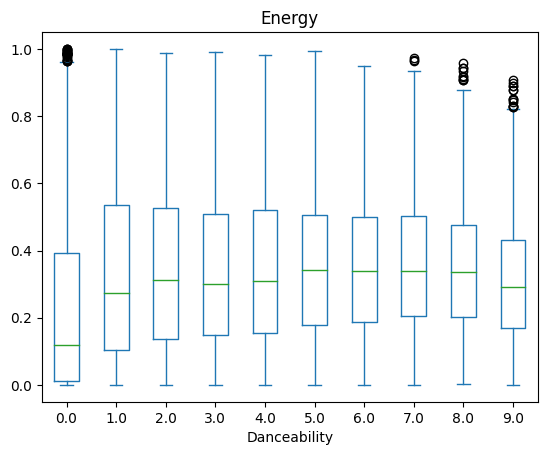

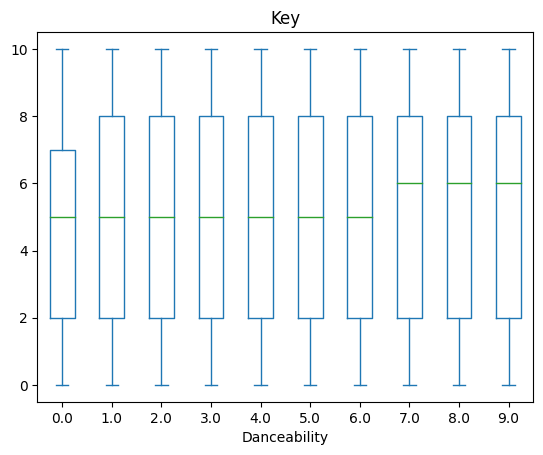

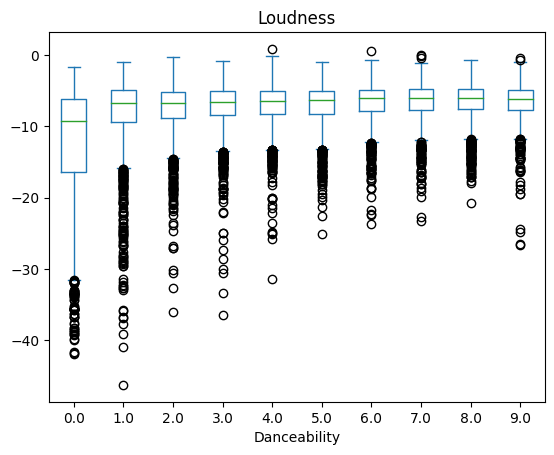

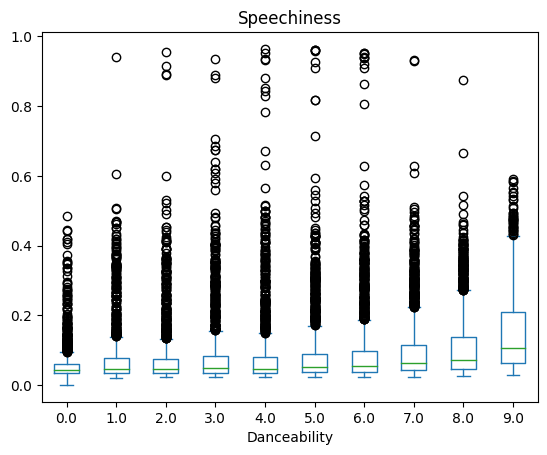

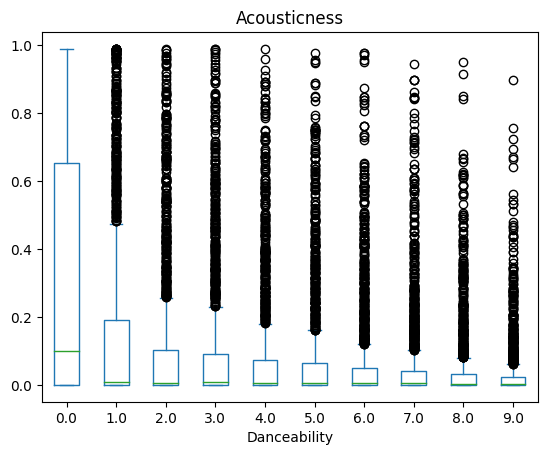

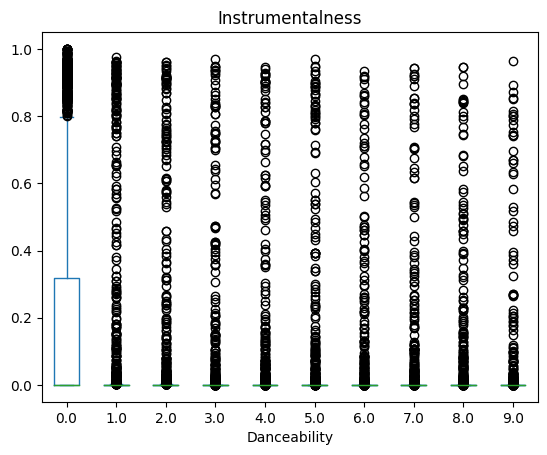

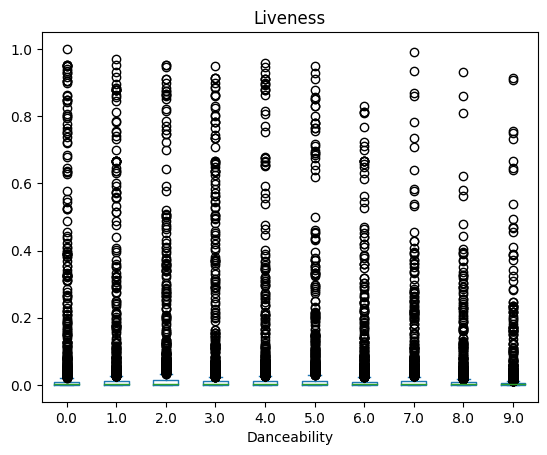

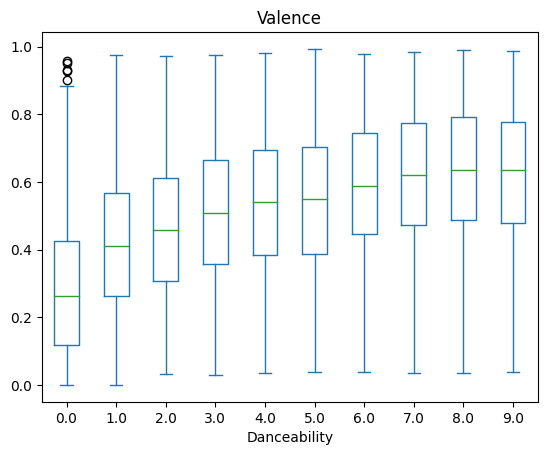

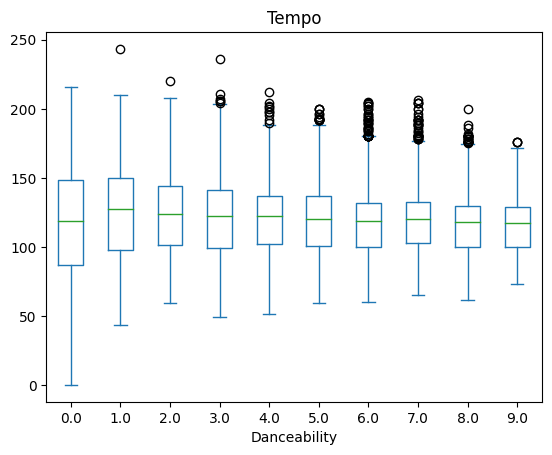

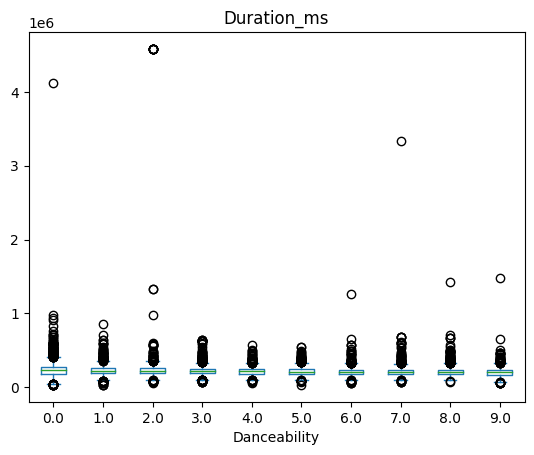

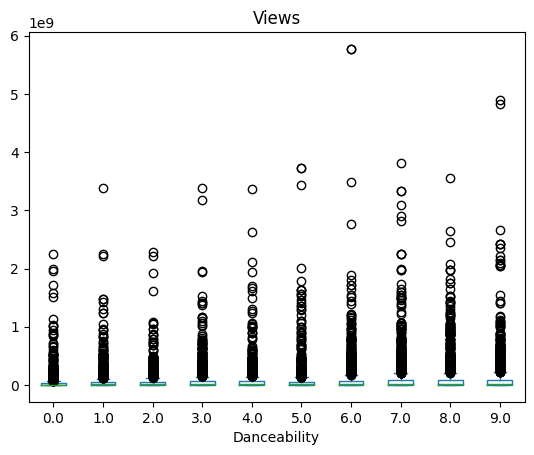

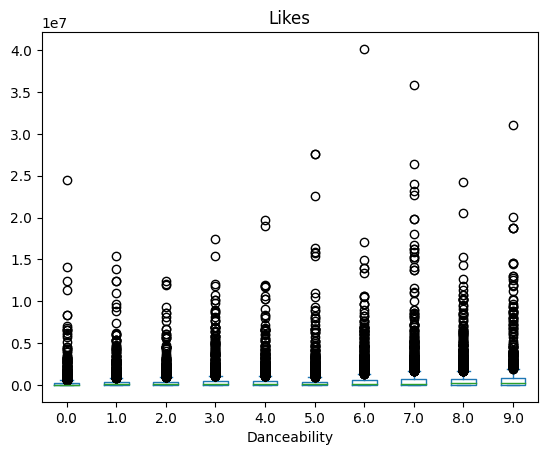

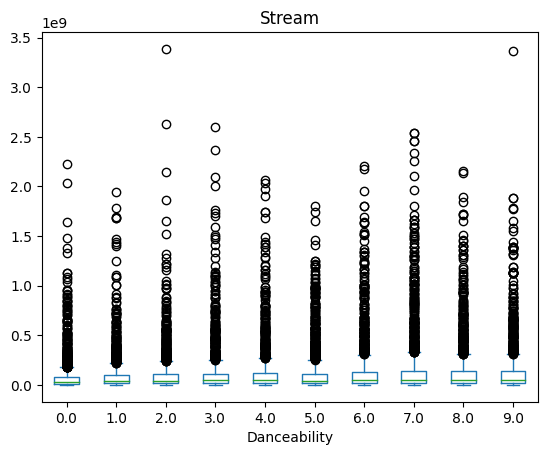

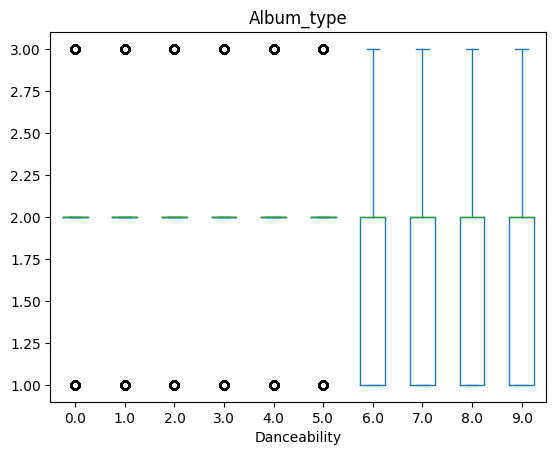

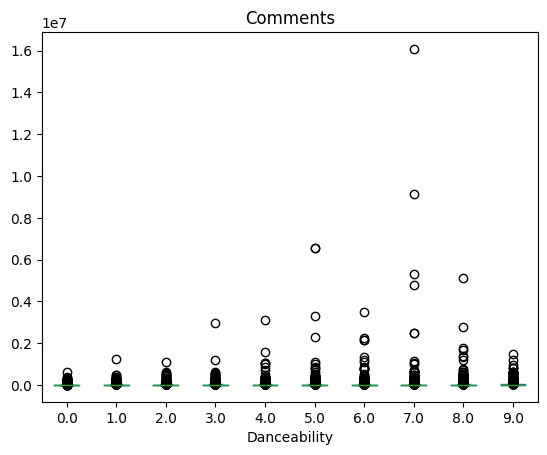

In [33]:
for i in range(train_x.shape[1]-2):
    pd.DataFrame({'Danceability': train_y, knn.df_knn.columns[i + 2]: train_x[:, i + 2]}).plot(kind='box',by='Danceability')
    plt.xlabel('Danceability')
    plt.show()

In [34]:
train_x_log = knn.log(train_x)

# Linear regression

In [24]:
def clip(x):
    return np.round(np.clip(x, 0, 9))

In [37]:
lm = TransformedTargetRegressor(regressor=make_pipeline(RobustScaler(), LinearRegression()), inverse_func=clip, check_inverse=False)
cv = cross_val_score(
    lm,
    train_x,
    train_y,
    cv=5,
    scoring="neg_mean_absolute_error"
)
cv

array([-1.88730344, -2.00058241, -2.01281305, -2.00844496, -2.01951077])

In [38]:
cv.mean()

-1.98573092603378

In [39]:
lm.fit(train_x, train_y)
lm.score(train_x, train_y)

0.29843811175857715

In [40]:
mean_absolute_error(train_y, lm.predict(train_x))

1.9661036691904485

In [41]:
lm = TransformedTargetRegressor(regressor=make_pipeline(RobustScaler(), LinearRegression()), inverse_func=clip, check_inverse=False)
cv = cross_val_score(
    lm,
    train_x_log,
    train_y,
    cv=5,
    scoring="neg_mean_absolute_error"
)
cv

array([-1.88293535, -1.95195108, -1.99359348, -1.95573675, -1.95777519])

In [42]:
cv.mean()

-1.9483983692486895

In [43]:
lm.fit(train_x_log, train_y)
lm.score(train_x_log, train_y)

0.31928102848218576

In [44]:
mean_absolute_error(train_y, lm.predict(train_x_log))

1.9262085032032614

# Polynomial transform

In [45]:
for i in range(2, 4):
    poly = PolynomialFeatures(i)
    train_x_p = poly.fit_transform(train_x_log)
    lm = TransformedTargetRegressor(regressor=make_pipeline(RobustScaler(), LinearRegression()), inverse_func=clip, check_inverse=False)
    cv = cross_val_score(
        lm,
        train_x_p,
        train_y,
        cv=5,
        scoring="neg_mean_absolute_error"
    )
    print("CV: ", cv)
    print("mean CV: ", cv.mean())
    lm.fit(train_x_p, train_y)
    print("R2: ", lm.score(train_x_p, train_y))
    print("MAE: ", mean_absolute_error(train_y, lm.predict(train_x_p)))

CV:  [-1.72772277 -1.76441468 -1.76237624 -1.78771112 -1.82906232]
mean CV:  -1.7742574257425745
R2:  0.4259825105400713
MAE:  1.7359930110658124
CV:  [-1.74082702 -1.78712871 -1.73791497 -1.80547467 -1.82585906]
mean CV:  -1.779440885264997
R2:  0.48457782822151874
MAE:  1.6206173558532324


In [23]:
poly = PolynomialFeatures(2)
train_x_2 = poly.fit_transform(train_x_log)
poly = PolynomialFeatures(3)
train_x_3 = poly.fit_transform(train_x_log)

# Lasso and Ridge regression

In [35]:
param_space = {
    'regressor__lasso__alpha': (0.000, 0.001), #regularizer
}
lasso = TransformedTargetRegressor(regressor=make_pipeline(RobustScaler(), Lasso()), inverse_func=clip, check_inverse=False)
lasso_optimizer = BayesSearchCV(lasso, param_space, n_iter=30, cv=5, scoring='neg_mean_absolute_error', random_state=26)
lasso_optimizer.fit(train_x_2, train_y)
best_lasso = lasso_optimizer.best_estimator_

c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e+04, tolerance: 1.117e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.441e+04, tolerance: 1.092e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

In [36]:
cv = cross_val_score(
    best_lasso,
    train_x_2,
    train_y,
    cv=5,
    scoring="neg_mean_absolute_error"
)
best_lasso.fit(train_x_2, train_y)
print(lasso_optimizer.best_params_)
print("CV: ", cv)
print("mean CV: ", cv.mean())
print("MAE: ", mean_absolute_error(train_y, best_lasso.predict(train_x_2)))
#mean_absolute_error(train_y, cross_val_predict(best_lasso, train_x_2, train_y, cv=5))

c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.207e+04, tolerance: 1.117e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.088e+04, tolerance: 1.092e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

OrderedDict([('regressor__lasso__alpha', 0.0008256778213555728)])
CV:  [-1.72481072 -1.76849156 -1.77402446 -1.7813046  -1.81712289]
mean CV:  -1.7731508444962145
MAE:  1.7470588235294118


c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e+04, tolerance: 1.403e+01
  model = cd_fast.enet_coordinate_descent(


In [31]:
param_space = {
    'regressor__ridge__alpha': (0.1, 10), #regularizer
}
ridge = TransformedTargetRegressor(regressor=make_pipeline(RobustScaler(), Ridge()), inverse_func=clip, check_inverse=False)
ridge_optimizer = BayesSearchCV(ridge, param_space, n_iter=30, cv=5, scoring='neg_mean_absolute_error', random_state=26)
ridge_optimizer.fit(train_x_2, train_y)
best_ridge2 = ridge_optimizer.best_estimator_

In [32]:
cv = cross_val_score(
    best_ridge2,
    train_x_2,
    train_y,
    cv=5,
    scoring="neg_mean_absolute_error"
)
best_ridge2.fit(train_x_2, train_y)
print(ridge_optimizer.best_params_)
print("CV: ", cv)
print("mean CV: ", cv.mean())
print("MAE: ", mean_absolute_error(train_y, best_ridge2.predict(train_x_2)))

OrderedDict([('regressor__ridge__alpha', 0.7494852650286973)])
CV:  [-1.72451951 -1.76004659 -1.76674432 -1.78479907 -1.82382062]
mean CV:  -1.771986022131625
MAE:  1.7362842166569599


In [33]:
param_space = {
    'regressor__ridge__alpha': (0.1, 1), #regularizer
}
ridge = TransformedTargetRegressor(regressor=make_pipeline(RobustScaler(), Ridge()), inverse_func=clip, check_inverse=False)
ridge_optimizer = BayesSearchCV(ridge, param_space, n_iter=30, cv=5, scoring='neg_mean_absolute_error', random_state=26)
ridge_optimizer.fit(train_x_3, train_y)
best_ridge3 = ridge_optimizer.best_estimator_

c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objectiv

In [34]:
cv = cross_val_score(
    best_ridge3,
    train_x_3,
    train_y,
    cv=5,
    scoring="neg_mean_absolute_error"
)
best_ridge3.fit(train_x_3, train_y)
print(ridge_optimizer.best_params_)
print("CV: ", cv)
print("mean CV: ", cv.mean())
print("MAE: ", mean_absolute_error(train_y, best_ridge3.predict(train_x_3)))

OrderedDict([('regressor__ridge__alpha', 0.18742601763017586)])
CV:  [-1.72218987 -1.74403029 -1.73296447 -1.8019802  -1.80867793]
mean CV:  -1.761968549796156
MAE:  1.6453115899825277


In [371]:
test_df = pd.read_csv("kaggle/html2023-spring-final-project/test.csv", delimiter=",", header=0)
test_x = knn.log_transform(knn.transform(test_df))
test_x_2 = PolynomialFeatures(2).fit_transform(test_x)
test_x_3 = PolynomialFeatures(3).fit_transform(test_x)

c:\Users\sciph\anaconda3\envs\machine-learning\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [373]:
id = test_df[['id']].copy()
id = id.to_numpy()
submit = np.zeros((test_df.shape[0], 2))
submit[:, 0] = id[:, 0]

submit[:, 1] = best_ridge2.predict(test_x_2)
df = pd.DataFrame(submit, columns = ['id','Danceability'])
df = df.astype({"id": int})
df.to_csv('ridge2_submission.csv', index=False)

In [374]:
id = test_df[['id']].copy()
id = id.to_numpy()
submit = np.zeros((test_df.shape[0], 2))
submit[:, 0] = id[:, 0]

submit[:, 1] = best_ridge3.predict(test_x_3)
df = pd.DataFrame(submit, columns = ['id','Danceability'])
df = df.astype({"id": int})
df.to_csv('ridge3_submission.csv', index=False)

# 3rd-degree kernel SVR

In [46]:
param_space = {
    'regressor__svr__C': (0.001, 1000),
    'regressor__svr__gamma': (0, 1),
}
svm = TransformedTargetRegressor(regressor=make_pipeline(RobustScaler(), SVR(kernel='poly')), inverse_func=clip, check_inverse=False)
svm_optimizer = BayesSearchCV(svm, param_space, n_iter=30, cv=5, scoring='neg_mean_absolute_error', random_state=26)
svm_optimizer.fit(train_x_log, train_y)
best_svm = svm_optimizer.best_estimator_
#mean_absolute_error(train_y, cross_val_predict(best_svm, train_x, train_y, cv=5))

In [ ]:
cv = cross_val_score(
    best_svm,
    train_x,
    train_y,
    cv=5,
    scoring="neg_mean_absolute_error"
)
best_svm.fit(train_x_log, train_y)
print(svm_optimizer.best_params_)
print("CV: ", cv)
print("mean CV: ", cv.mean())
print("MAE: ", mean_absolute_error(train_y, best_svm.predict(train_x_log)))